# **Credit Card Anomaly Detection**



---





# About The Dataset

>- **Context:**  It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

>- **Content:** This data set contains 28481 data points, but we are only gonna use a 5,000 transaction subset. The column `"Class"` in the data set gives us information about the fraud transaction. If `Class=1` means the transaction is fraud. If `Class=0` means the transaction is valid.
This is a classification problem, in which we will do anomaly detection using `Isolation Forest` algorithm. Given the class imbalance ratio, we are gonna measure the accuracy using the `ROC-AUC` (Receiver Operating Characteristic - Area Under Curve) and `PR-AUC` (Precision-Recall AUC / Average Precision). Confusion matrix accuracy is not meaningful for unbalanced classification.

# Setup

In [1]:
!pip install colorama

In [2]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, make_scorer, recall_score, f1_score , confusion_matrix , classification_report , ConfusionMatrixDisplay ,roc_curve ,roc_auc_score , precision_recall_curve , auc
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import LocalOutlierFactor
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from colorama import Fore
import seaborn as sns
import os
import random

sns.set_style("darkgrid")

# Upload Dataset from Kaggle

In [3]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rimchehade","key":"238bc74dee44f17ca0a05da150e5090f"}'}

In [4]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download the dataset
!kaggle datasets download -d mlg-ulb/creditcardfraud

Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.11GB/s]


In [5]:
import zipfile

with zipfile.ZipFile("creditcardfraud.zip", 'r') as zip_ref:
    zip_ref.extractall("./data")

In [6]:
os.listdir("./data")

['creditcard.csv']

In [7]:
df = pd.read_csv("./data/creditcard.csv")

In [8]:
# Take a random subset of 5,000 transactions
df = df.sample(5000, random_state=42)

In [9]:
print("Shape:", df.shape)
df.head()

Shape: (5000, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
43428,41505.0,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,-8.507059,...,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,364.19,1
49906,44261.0,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,0.899746,...,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,520.12,0
29474,35484.0,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,-0.971747,...,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,31.00,0
276481,167123.0,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,-0.484715,...,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,1.50,0
278846,168473.0,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,0.363241,...,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0.89,0


# Checking the data

In [10]:
# Check missing values
missing = df.isnull().sum().sum()
print(f"Total missing values: {missing}")

# Quick statistics
df.describe().T

Total missing values: 0


,count,mean,std,min,25%,50%,75%,max
Time,5000.0,94557.283800,47086.875638,23.000000,53973.000000,84402.500000,138888.250000,172782.000000
V1,5000.0,-0.014196,1.948877,-32.058119,-0.941203,0.036581,1.314442,2.368294
V2,5000.0,-0.000891,1.752375,-48.060856,-0.588854,0.096409,0.804390,9.252013
V3,5000.0,0.000648,1.455444,-18.649853,-0.906400,0.160341,1.027443,3.760965
V4,5000.0,0.011844,1.386241,-4.629003,-0.824201,-0.015156,0.746837,10.856608
V5,5000.0,0.025717,1.390851,-20.787846,-0.668073,-0.032107,0.635419,26.647697
V6,5000.0,-0.027056,1.319011,-20.869626,-0.773761,-0.282333,0.369946,13.085694
V7,5000.0,0.015709,1.157703,-16.701694,-0.535696,0.047957,0.574414,17.256623
V8,5000.0,-0.001811,1.068458,-24.959702,-0.212620,0.016145,0.316012,8.533646
V9,5000.0,0.006753,1.081889,-8.507059,-0.623824,-0.049677,0.591196,10.370658


In [11]:
df.duplicated().sum()

np.int64(0)

In [12]:
df['Class'].value_counts()

,count
Class,
0,4994
1,6


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5000 entries, 43428 to 98463
Data columns (total 31 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Time    5000 non-null   float64
 1   V1      5000 non-null   float64
 2   V2      5000 non-null   float64
 3   V3      5000 non-null   float64
 4   V4      5000 non-null   float64
 5   V5      5000 non-null   float64
 6   V6      5000 non-null   float64
 7   V7      5000 non-null   float64
 8   V8      5000 non-null   float64
 9   V9      5000 non-null   float64
 10  V10     5000 non-null   float64
 11  V11     5000 non-null   float64
 12  V12     5000 non-null   float64
 13  V13     5000 non-null   float64
 14  V14     5000 non-null   float64
 15  V15     5000 non-null   float64
 16  V16     5000 non-null   float64
 17  V17     5000 non-null   float64
 18  V18     5000 non-null   float64
 19  V19     5000 non-null   float64
 20  V20     5000 non-null   float64
 21  V21     5000 non-null   float64
 22  

While exploring the data we noticed:

*  Number of Rows is :  `5000`
     
*  Number of columns is :  `31`

*  There are no null values in the data

*  There are no duplicates

*  There are some values in `Time` and `Amount`columns that are too large for others and for the values in the data set in general

*  There is `1` column int64 and `30` float64

*  All values in data are `numeric`

*  we have `6` frauds out of `5000` transactions.



# EDA (Exploratory Data Analysis)

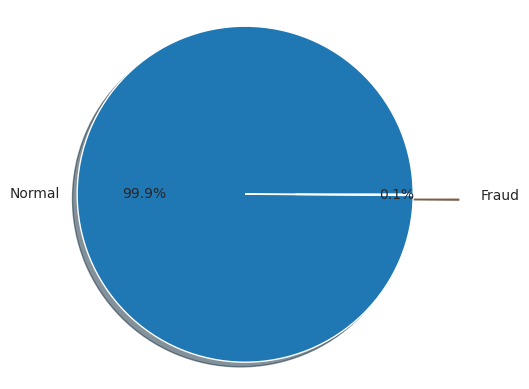

In [14]:
plt.pie([(df['Class']==0).sum() , (df['Class']==1).sum()], labels=('Normal' , 'Fraud'), explode= [0,.3], autopct= '%1.1f%%', shadow= True)
plt.axis('equal')
plt.show()

We have a highly imbalanced dataset on our hands.

In [15]:
# defining the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=18)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

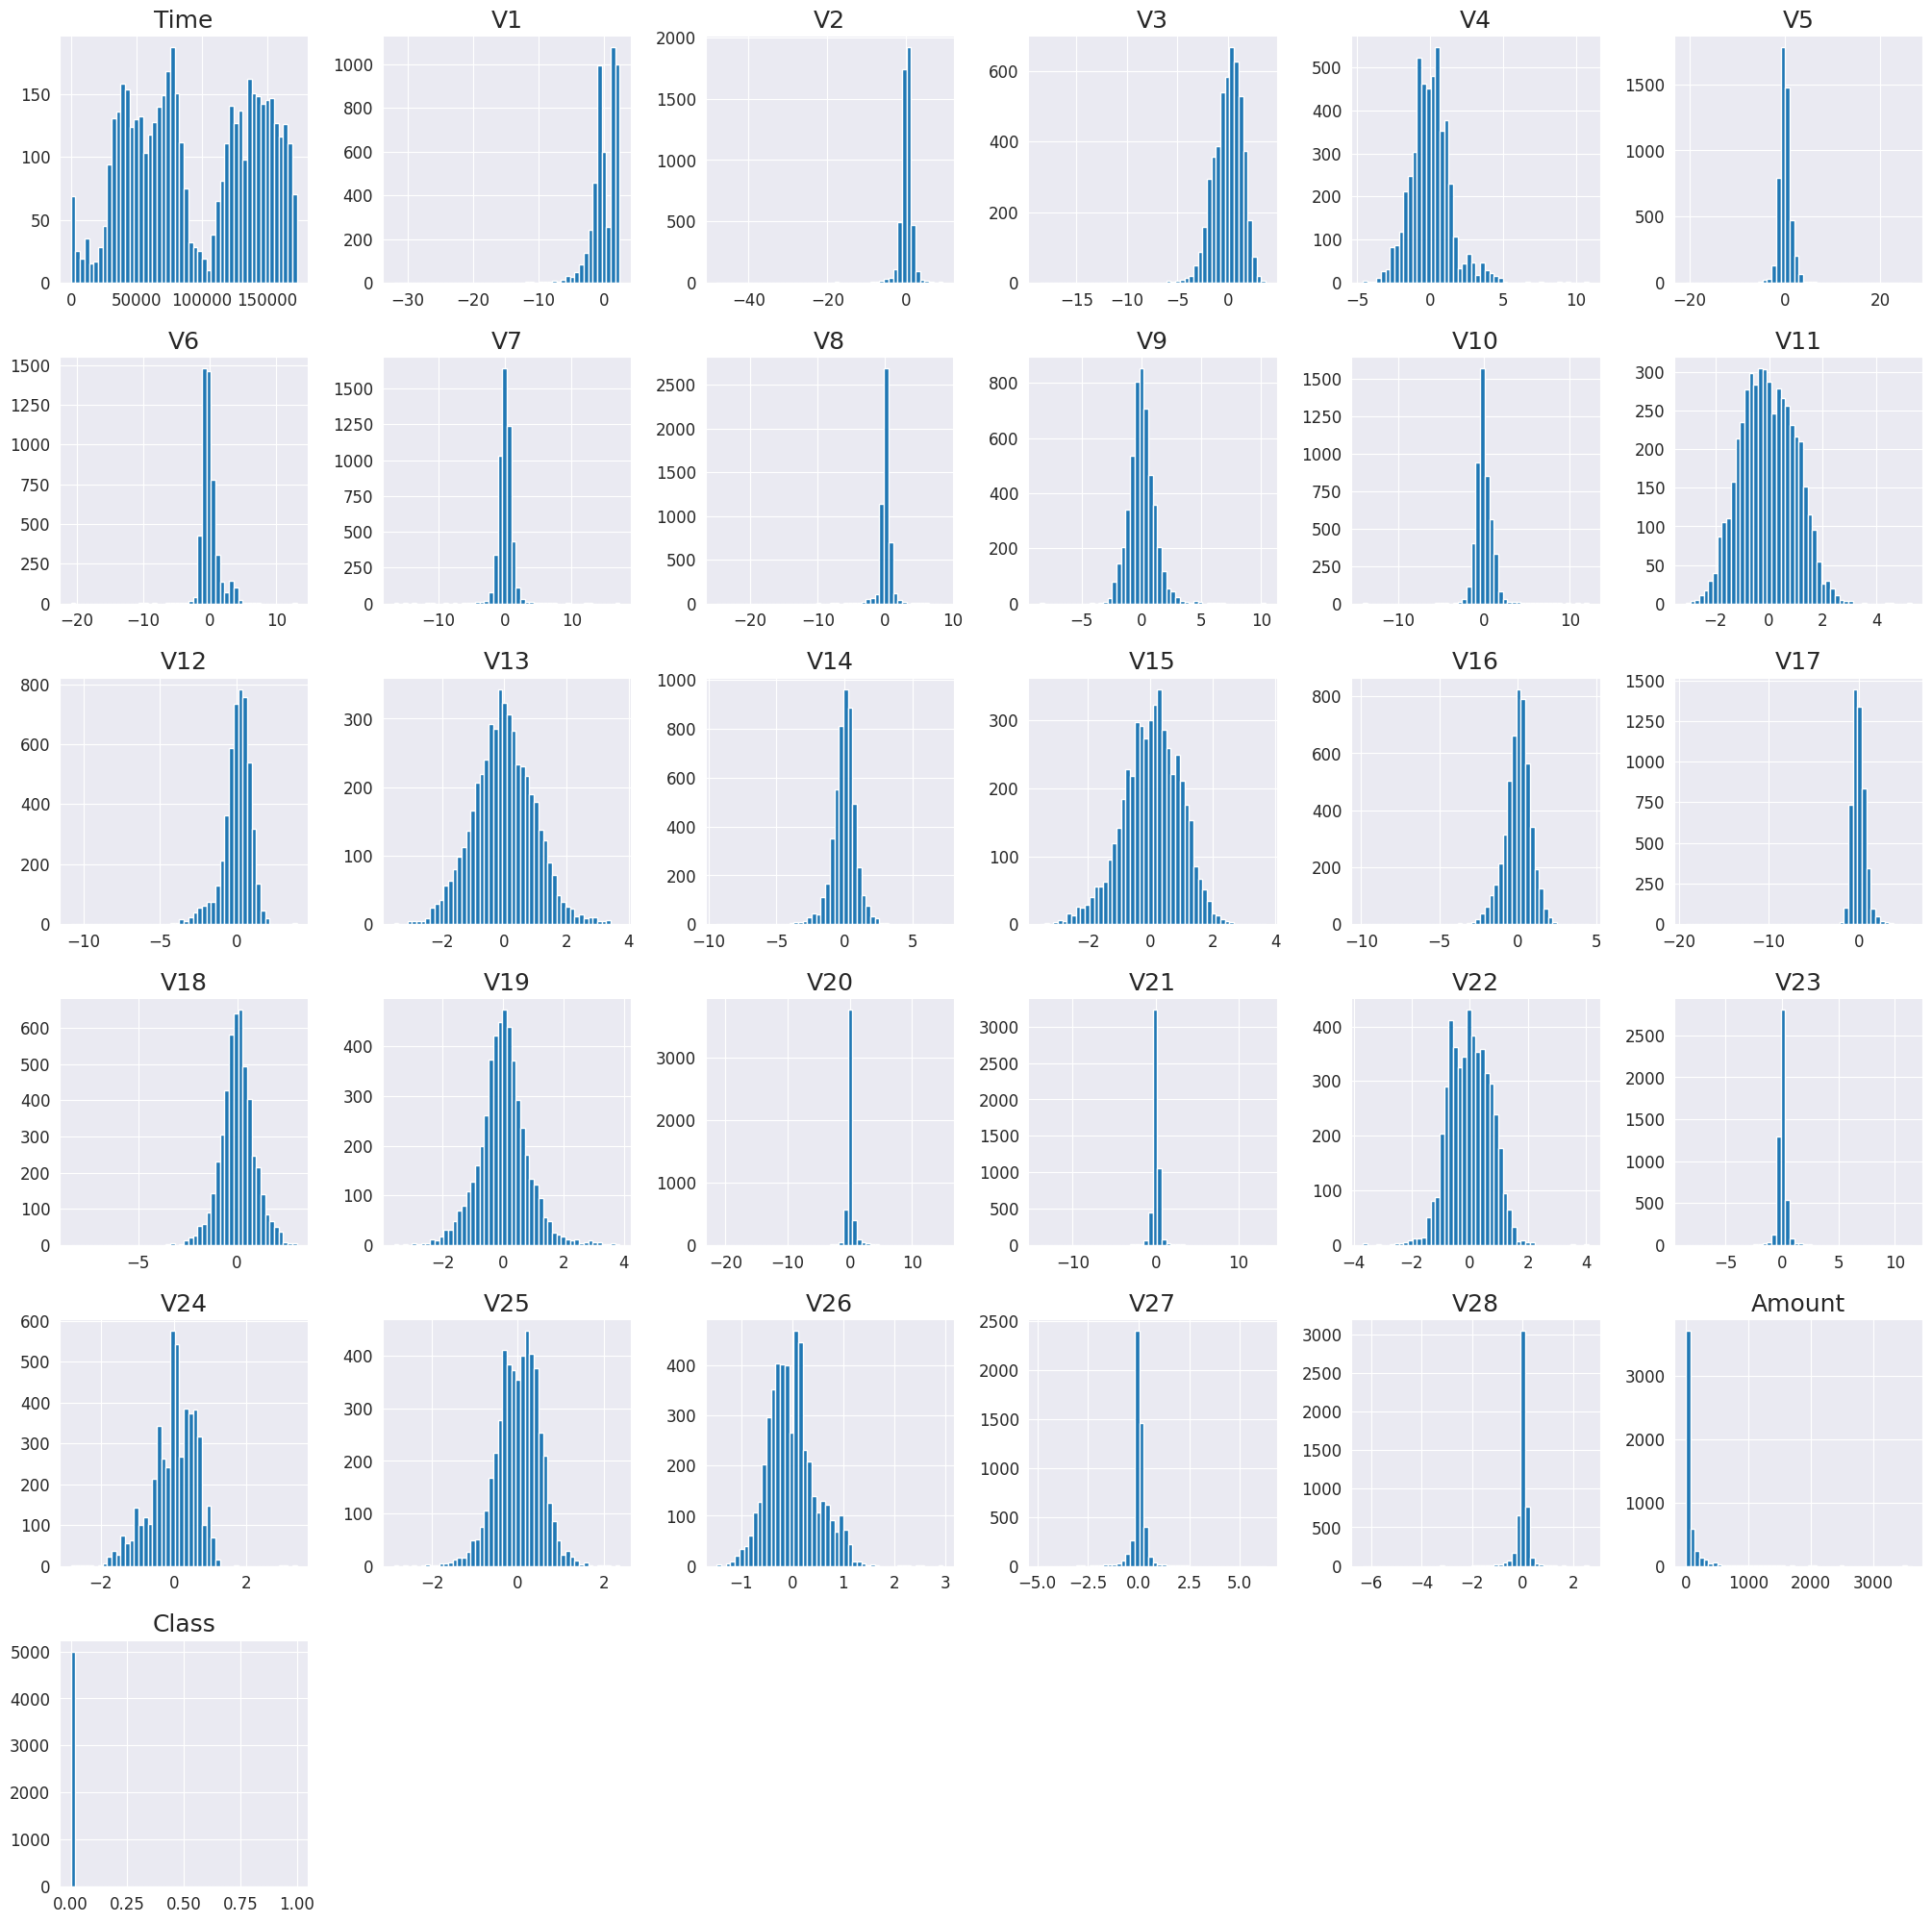

In [16]:
# Plot histogram of each paramater
df.hist(bins=50, figsize=(25, 25) , grid = True)
plt.show()

We notice that all the features are normally shaped except fot the `Time` and `Amount`, which we will scale later.

Now let's see the columns of `Time` and `Amount` with  `Class` column

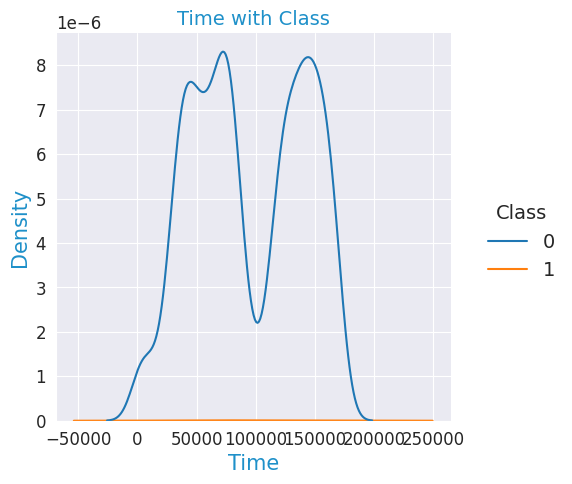

In [17]:
sns.displot(data=df, x="Time", kind="kde", hue="Class")

plt.rc('ytick', labelsize=10)
plt.ylabel('Density' , size=15, color='#1e90c9')
plt.xlabel('Time' , size=15, color='#1e90c9')
plt.title('Time with Class' , size = 14 , color='#1e90c9')

plt.show()

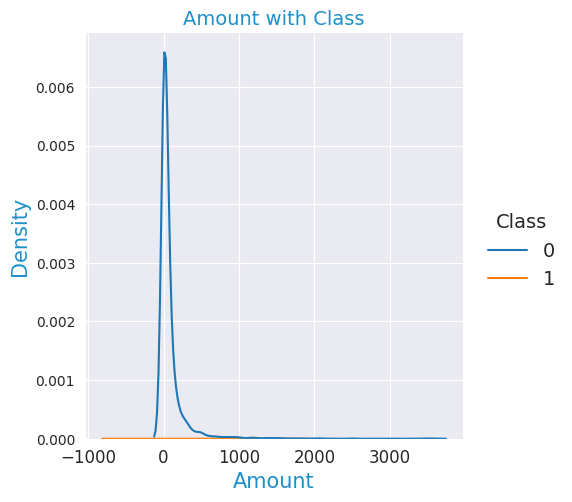

In [18]:
sns.displot(data=df, x="Amount", kind="kde", hue="Class")

plt.rc('ytick', labelsize=10)
plt.ylabel('Density' , size=15, color='#1e90c9')
plt.xlabel('Amount' , size=15, color='#1e90c9')
plt.title('Amount with Class' , size = 14 , color='#1e90c9')

plt.show()

 OK, let's see the `Amount` with `Class` better

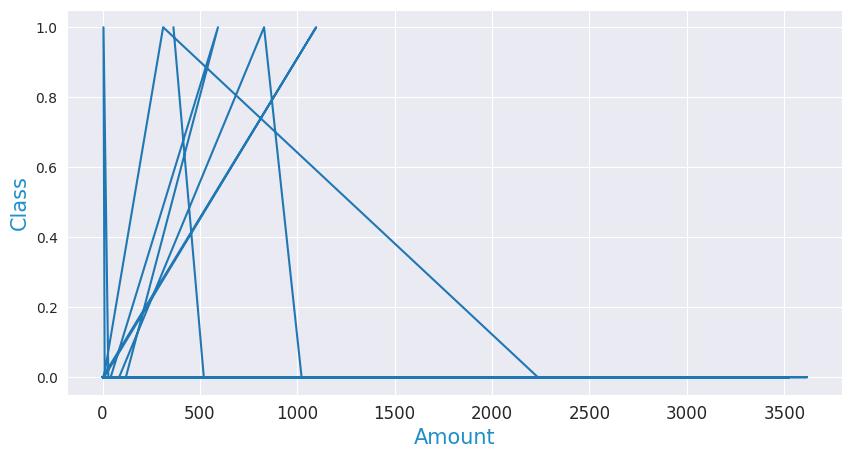

In [19]:
plt.figure(figsize = (10,5))
plt.xlabel('Amount' , size = 15,color='#1e90c9')
plt.ylabel('Class' , size = 15,color='#1e90c9')

plt.plot(df['Amount'] , df['Class'])
plt.show()

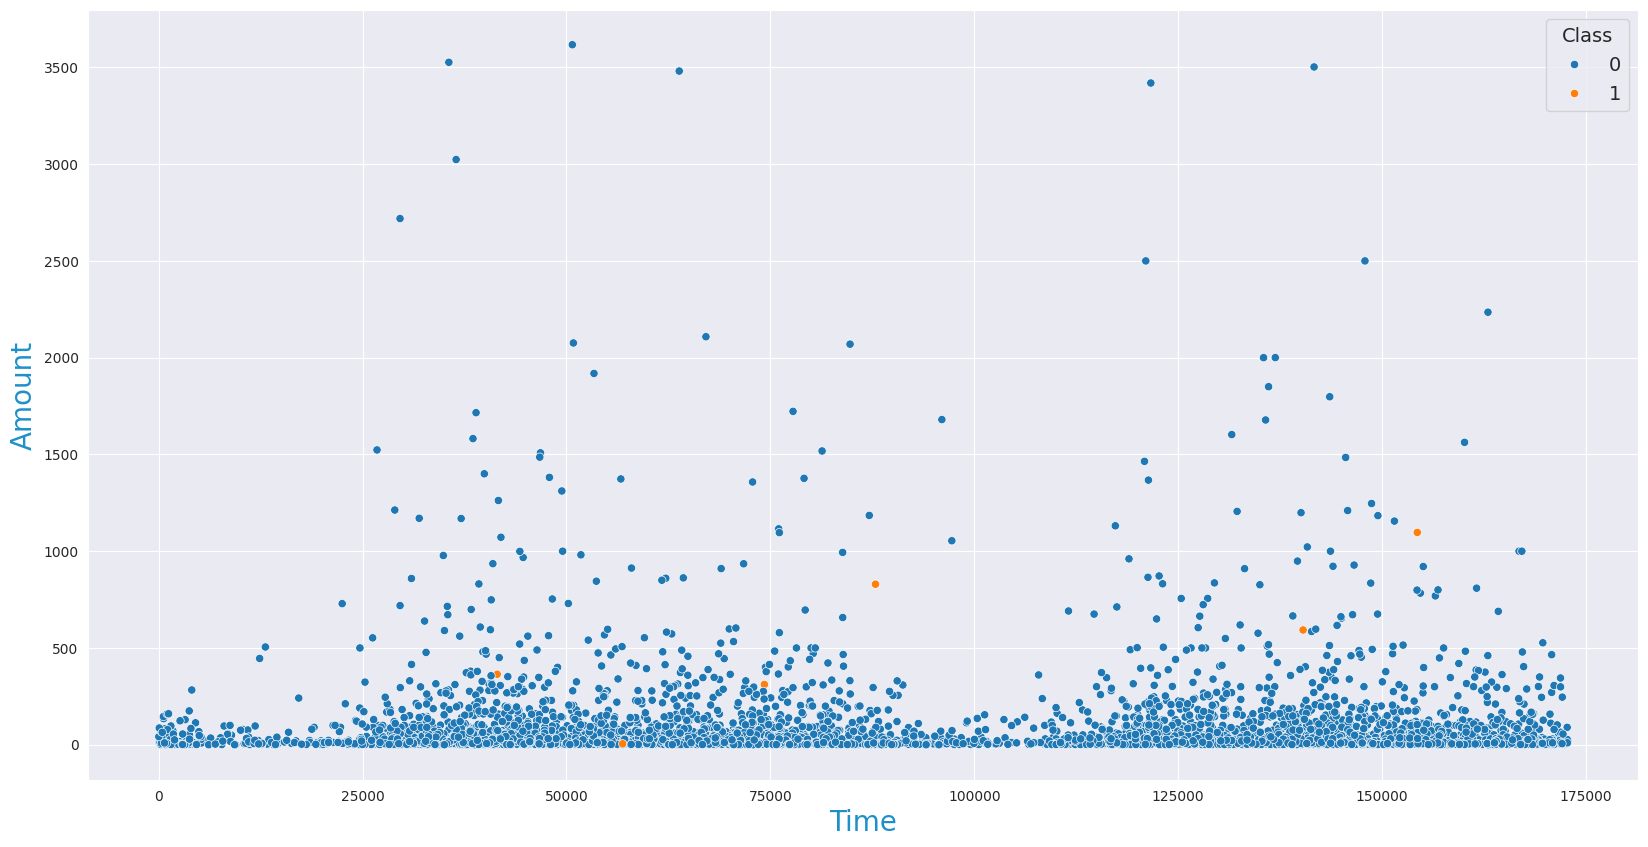

In [20]:
plt.figure(figsize = (20,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.xlabel('Time' , size = 20,color='#1e90c9')
plt.ylabel('Amount' , size = 20,color='#1e90c9')

sns.scatterplot(data = df , x = 'Time' , y = 'Amount' , hue = 'Class')
plt.show()

Here, we can see that there is no specific time or Amount in which fraud is alot, fraud is distributed over all the data in both and no Correlations.

/tmp/ipython-input-3797485793.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Class', data=df, palette='Set2')


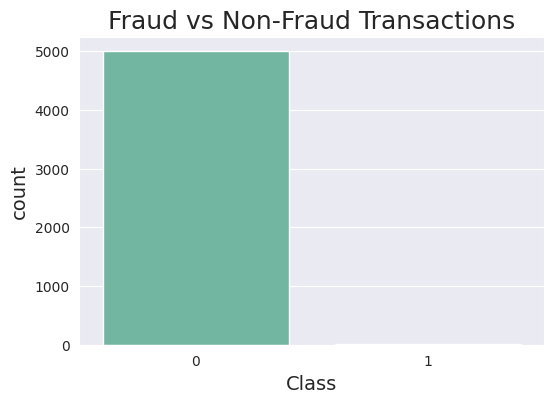

In [21]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, palette='Set2')
plt.title('Fraud vs Non-Fraud Transactions')
plt.show()

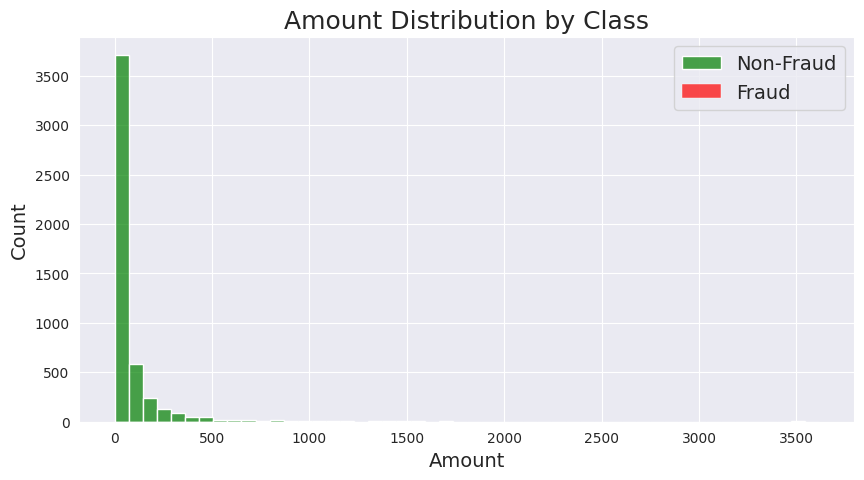

In [22]:
# Distribution of Amount by Class
plt.figure(figsize=(10,5))
sns.histplot(df[df['Class']==0]['Amount'], bins=50, color='green', label='Non-Fraud', alpha=0.7)
sns.histplot(df[df['Class']==1]['Amount'], bins=50, color='red', label='Fraud', alpha=0.7)
plt.legend()
plt.title('Amount Distribution by Class')
plt.show()

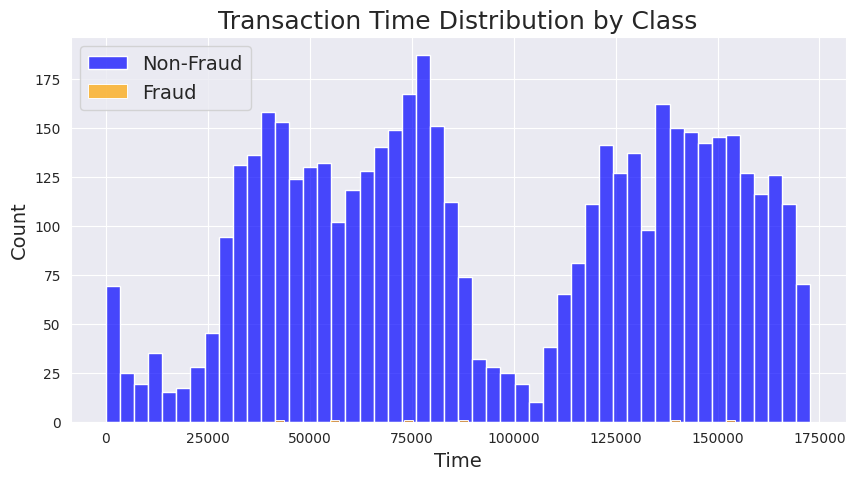

In [23]:
# Time Feature Analysis
plt.figure(figsize=(10,5))
sns.histplot(df[df['Class']==0]['Time'], bins=50, color='blue', label='Non-Fraud', alpha=0.7)
sns.histplot(df[df['Class']==1]['Time'], bins=50, color='orange', label='Fraud', alpha=0.7)
plt.legend()
plt.title('Transaction Time Distribution by Class')
plt.show()

# Looking for Correlations

First, we will look into correlations with `Class` column

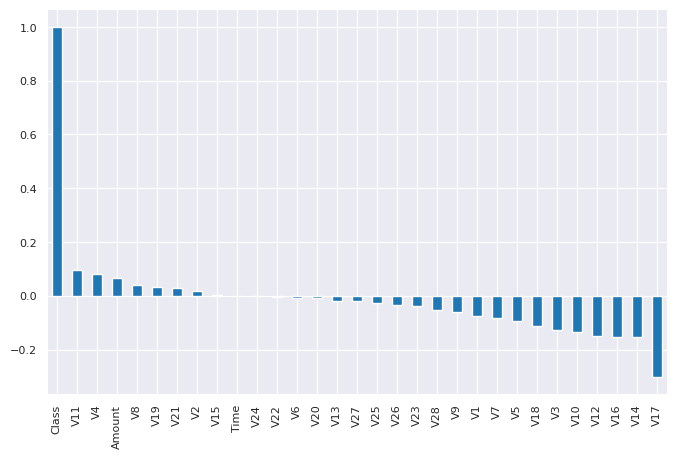

In [24]:
df_correlation = df.corr()

plt.figure(figsize = (8,5))
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
df_correlation['Class'].sort_values(ascending = False).plot(kind = 'bar')
plt.show()

* Negative Correlations: V17, V14, V12 and V10 are negatively correlated. Notice
how the lower these values are, the more likely the end result will be a fraud transaction.

* Positive Correlations: V2, V4, V11, and V19 are positively correlated. Notice how the higher these values are, the more likely the end result will be a fraud transaction.

# PCA

We will use PCA for visualization

In [25]:
from sklearn.decomposition import PCA

# 3D
pca = PCA(n_components=3)
X3D = pca.fit_transform(df.drop(['Time', 'Amount','Class'] , axis = 1))
# we drop Time and Amount because we saw them above

# 2D
pca = PCA(n_components=2)
X2D = pca.fit_transform(df.drop(['Time', 'Amount','Class'] , axis = 1))

In [26]:
import plotly.express as px

fig = px.scatter_3d(X3D, x = 0,y=1,z=2,
                   color = df['Class'] ,title = '3D')
fig.show()

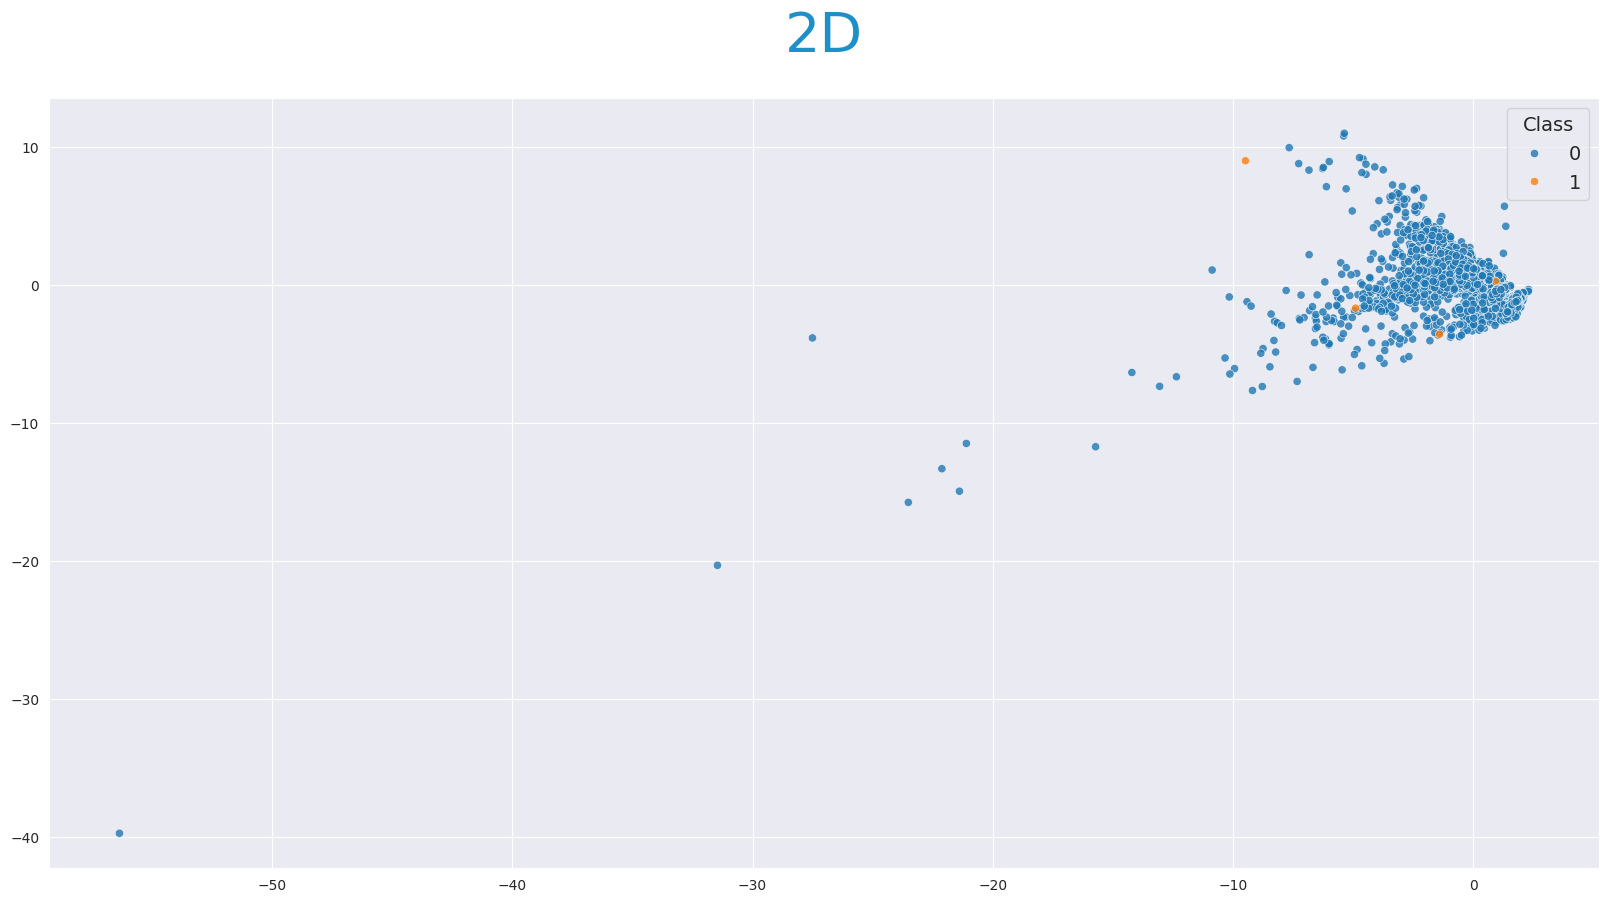

In [27]:
plt.figure(figsize = (20,10))
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)
plt.title('2D' , size = 40 , y = 1.05 , color='#1e90c9')

sns.scatterplot(x = X2D[:,0] , y = X2D[:,1] , hue =df['Class'] , alpha = .8 )
plt.show()

We can detect a pattern

# Data Cleaning and Preprocessing

In [28]:
# Since most of our data has already been scaled we should scale the columns that are left to scale (Amount and Time)

from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers , scaled feature= feature−median / IQR.
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

In [29]:
scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
# Amount and Time are Scaled!

df.head()

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
43428,4.885841,-0.505180,-16.526507,8.584972,-18.649853,9.505594,-13.793819,-2.832404,-16.701694,7.517344,...,-1.514923,1.190739,-1.127670,-2.358579,0.673461,-1.413700,-0.462762,-2.018575,-1.042804,1
49906,7.107462,-0.472724,0.339812,-2.743745,-0.134070,-1.385729,-1.451413,1.015887,-0.524379,0.224060,...,0.506044,-0.213436,-0.942525,-0.526819,-1.156992,0.311211,-0.746647,0.040996,0.102038,0
29474,0.138700,-0.576086,1.399590,-0.590701,0.168619,-1.029950,-0.539806,0.040444,-0.712567,0.002299,...,0.212877,0.102398,0.168269,-0.166639,-0.810250,0.505083,-0.232340,0.011409,0.004634,0
276481,-0.281603,0.974154,-0.432071,1.647895,-1.669361,-0.349504,0.785785,-0.630647,0.276990,0.586025,...,-0.244633,0.358932,0.873663,-0.178642,-0.017171,-0.207392,-0.157756,-0.237386,0.001934,0
278846,-0.290294,0.990052,2.014160,-0.137394,-1.015839,0.327269,-0.182179,-0.956571,0.043241,-0.160746,...,-0.255293,-0.238644,-0.616400,0.347045,0.061561,-0.360196,0.174730,-0.078043,-0.070571,0


# Model Training: Isolation Forest

We will use the following techniques:

**Local Outlier Factor (LOF)**

The anomaly score of each sample is called Local Outlier Factor. It measures the local deviation of density of a given sample with respect to its neighbors. It is local in that the anomaly score depends on how isolated the object is with respect to the surrounding neighborhood.

**Isolation Forest Algorithm**

The IsolationForest 'isolates' observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature.

Since recursive partitioning can be represented by a tree structure, the number of splittings required to isolate a sample is equivalent to the path length from the root node to the terminating node.

This path length, averaged over a forest of such random trees, is a measure of normality and our decision function.

Random partitioning produces noticeably shorter paths for anomalies. Hence, when a forest of random trees collectively produce shorter path lengths for particular samples, they are highly likely to be anomalies.

In [30]:
x = df.drop('Class', axis=1)
y = df['Class']
Fraud = df[df['Class'] == 1]
Valid = df[df['Class'] == 0]

In [31]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, shuffle=True , stratify=y, random_state=42)
# stratify= y:  ensures that both the training and testing sets maintain the same proportion of fraud cases as the original dataset.

In [32]:
print("Training set anomalies:", sum(y_train == 1))
print("Testing set anomalies:", sum(y_test == 1))

Training set anomalies: 4
Testing set anomalies: 2


In [33]:
# Calculate the outlier fraction from the training data
outlier_fraction = len(y_train[y_train == 1]) / float(len(y_train[y_train == 0]))

# Define classifiers
classifiers = {
    "Isolation Forest": IsolationForest(max_samples=len(x_train),
                                         contamination=outlier_fraction,
                                         random_state=42),
    "Local Outlier Factor": LocalOutlierFactor(
        n_neighbors=20,
        contamination=outlier_fraction)
}

# Iterate through classifiers
for clf_name, clf in classifiers.items():

    # Fit the model and get predictions on the test set
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(x_test)
    else:
        clf.fit(x_train)
        y_pred = clf.predict(x_test)

    # Reshape the prediction values to 0 for valid, 1 for fraud.
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    n_errors = (y_pred != y_test).sum()

    # Run classification metrics
    print(f"\nModel: {clf_name}")
    print(f"Number of errors: {n_errors}")
    print(f"Accuracy Score: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n{classification_report(y_test, y_pred)}")


Model: Isolation Forest
Number of errors: 1
Accuracy Score: 0.9993
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1498
           1       1.00      0.50      0.67         2

    accuracy                           1.00      1500
   macro avg       1.00      0.75      0.83      1500
weighted avg       1.00      1.00      1.00      1500


Model: Local Outlier Factor
Number of errors: 2
Accuracy Score: 0.9987
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1498
           1       0.50      0.50      0.50         2

    accuracy                           1.00      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       1.00      1.00      1.00      1500



# Evaluation

In [34]:
iso_forest = IsolationForest(max_samples=len(x_train), contamination=outlier_fraction, random_state=1)
iso_forest.fit(x_train)

# Get anomaly scores from Isolation Forest
anomaly_scores = -iso_forest.decision_function(x_test)
y_pred = (anomaly_scores > np.percentile(anomaly_scores, 100 - outlier_fraction * 100)).astype(int)

# Evaluate ROC-AUC & PR-AUC
from sklearn.metrics import average_precision_score
roc_auc = roc_auc_score(y_test, anomaly_scores)
ap_score = average_precision_score(y_test, anomaly_scores)

print(f"ROC-AUC: {roc_auc:.4f}")
print(f"PR-AUC (Average Precision): {ap_score:.4f}")
print(classification_report(y_test, y_pred))

ROC-AUC: 0.9990
PR-AUC (Average Precision): 0.7000
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1498
           1       0.50      0.50      0.50         2

    accuracy                           1.00      1500
   macro avg       0.75      0.75      0.75      1500
weighted avg       1.00      1.00      1.00      1500



We notice a decrease in precision and PR-AUC because the data is `inbalanced`

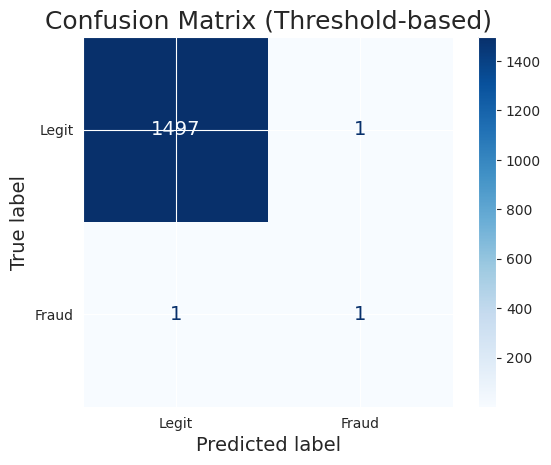

In [35]:
y_pred = (anomaly_scores > np.percentile(anomaly_scores, 100 - outlier_fraction * 100)).astype(int)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=['Legit', 'Fraud'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix (Threshold-based)")
plt.show()

**Interpretation:**

* True Negatives (TN): 1497

The model correctly identified 1497 legitimate transactions.

* False Positives (FP): 1

1 normal transaction was incorrectly flagged as fraud.

* False Negatives (FN): 1

1 fraud transaction was missed (classified as normal).

* True Positives (TP): 1

Only one fraudulent transaction was correctly detected.

**Observations:**

* High accuracy for normal cases (almost all normal transactions are correctly classified).


* Extremely low recall for frauds, only 1 out of 2 fraud cases detected.


* This is common for Isolation Forest if fraud cases are rare and/or not strongly separable in the feature space.


* Model is heavily biased toward predicting Normal (likely due to severe class imbalance).


* In a fraud detection context, missing fraud (FN) is more costly than a few false alarms (FP), so recall for fraud should be improved.



---



### **Conclusion:**

The Isolation Forest model demonstrated strong anomaly detection performance, correctly identifying the vast majority of normal and fraudulent cases, with only minimal misclassifications. Local Outlier Factor (LOF) results were excluded from final evaluation as the model was tested on the same data it was trained on, which could lead to an overly optimistic performance estimate.

* We might consider:

  - Tuning parameters (e.g., contamination)

  - Using other models

  - Combining predictions from multiple models

  - Enhancing feature engineering